# CCGANs - Context-Conditional Generative Adversarial Networks

Introduction to Context-Conditional Generative Adversarial Networks or CCGANs.

This notebook is organized follows:

1. **Background**
* **Definition**
* **Training CCGANs with Keras and TensorFlow**


## 1. Background



## 2. Definition

![ccgan](../img/ccgan.png)

## 3. Training CCGANs with Keras and TensorFlow

CCGANs implementation using ... the [Keras](https://keras.io/) library.

### 1. Load data

#### Load libraries

In [1]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, LeakyReLU, BatchNormalization
from keras.layers import Input, Flatten, Embedding, multiply, Dropout
from keras.optimizers import Adam
from keras import initializers

from keras_contrib.layers.normalization import InstanceNormalization
from keras.layers import Concatenate, GaussianNoise
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras import losses
from keras.utils import to_categorical
import keras.backend as K

# from scipy.misc import imresize
from skimage.transform import resize

Using TensorFlow backend.


#### Getting the data

In [3]:
# load dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

#### Explore visual data

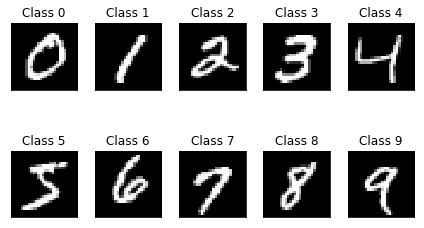

In [4]:
fig = plt.figure()
for i in range(10):
    plt.subplot(2, 5, i+1)
    x_y = X_train[y_train == i]
    plt.imshow(x_y[0], cmap='gray', interpolation='none')
    plt.title("Class %d" % (i))
    plt.xticks([])
    plt.yticks([])
    
plt.tight_layout()

#### Reshaping and normalizing the inputs

In [5]:
print('X_train.shape', X_train.shape)
print('y_train.shape', y_train.shape)

if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, 28, 28)
    X_test = X_test.reshape(X_test.shape[0], 1, 28, 28)
    input_shape = (1, 28, 28)
else:
    X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
    X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
    input_shape = (28, 28, 1)

# the generator is using tanh activation, for which we need to preprocess 
# the image data into the range between -1 and 1.

X_train = np.float32(X_train)
X_train = (X_train / 255 - 0.5) * 2
X_train = np.clip(X_train, -1, 1)

# y to categorical
num_classes = 10
y_train = to_categorical(y_train, num_classes=num_classes+1)

print('X_train reshape:', X_train.shape)
print('y_train reshape:', y_train.shape)

X_train.shape (60000, 28, 28)
y_train.shape (60000,)
X_train reshape: (60000, 28, 28, 1)
y_train reshape: (60000, 11)


In [6]:
X_train = resize(X_train, [X_train.shape[0], 32, 32, 1])
print('X_train reshape:', X_train.shape)

/usr/local/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


X_train reshape: (60000, 32, 32, 1)


### 2. Define model

#### Generator

"U-Net"

In [7]:
# # latent space dimension
# latent_dim = 100

# # imagem dimension 28x28
# img_dim = 784

init = initializers.RandomNormal(stddev=0.02)

# # Generator network
# generator = Sequential()

# # Input layer and hidden layer 1
# generator.add(Dense(128, input_shape=(latent_dim,),
#                     kernel_initializer=init))
# generator.add(BatchNormalization())
# generator.add(LeakyReLU(0.2))

# # Hidden layer 2
# generator.add(Dense(256))
# generator.add(LeakyReLU(0.2))
# generator.add(BatchNormalization())

# # Hidden layer 3
# generator.add(Dense(512))
# generator.add(LeakyReLU(0.2))
# generator.add(BatchNormalization())

# # Output layer 
# generator.add(Dense(img_dim, activation='tanh'))

In [8]:
 # Number of filters in first layer of generator
gf = 32
k = 4
s = 2

# imagem shape 28x28x1
img_shape = X_train[0].shape

# Generator input
img_g = Input(shape=(img_shape))

# Downsampling
d1 = Conv2D(gf, kernel_size=k, strides=s, padding='same')(img_g)
d1 = LeakyReLU(alpha=0.2)(d1)

d2 = Conv2D(gf*2, kernel_size=k, strides=s, padding='same')(d1)
d2 = LeakyReLU(alpha=0.2)(d2)
d2 = BatchNormalization(momentum=0.8)(d2)

d3 = Conv2D(gf*4, kernel_size=k, strides=s, padding='same')(d2)
d3 = LeakyReLU(alpha=0.2)(d3)
d3 = BatchNormalization(momentum=0.8)(d3)

d4 = Conv2D(gf*8, kernel_size=k, strides=s, padding='same')(d3)
d4 = LeakyReLU(alpha=0.2)(d4)
d4 = BatchNormalization(momentum=0.8)(d4)

# Upsampling
u1 = UpSampling2D(size=2)(d4)
u1 = Conv2D(gf*4, kernel_size=k, strides=1, padding='same', activation='relu')(u1)
u1 = BatchNormalization(momentum=0.8)(u1)

u2 = Concatenate()([u1, d3])
u2 = UpSampling2D(size=2)(u2)
u2 = Conv2D(gf*2, kernel_size=k, strides=1, padding='same', activation='relu')(u2)
u2 = BatchNormalization(momentum=0.8)(u2)

u3 = Concatenate()([u2, d2])
u3 = UpSampling2D(size=2)(u3)
u3 = Conv2D(gf, kernel_size=k, strides=1, padding='same', activation='relu')(u3)
u3 = BatchNormalization(momentum=0.8)(u3)

u4 = Concatenate()([u3, d1])
u4 = UpSampling2D(size=2)(u4)
u4 = Conv2D(1, kernel_size=4, strides=1, padding='same', activation='tanh')(u4)

generator = Model(img_g, u4)

#### Generator model visualization

In [9]:
# prints a summary representation of your model
generator.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 16, 32)   544         input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 16, 16, 32)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 8, 8, 64)     32832       leaky_re_lu_1[0][0]              
__________________________________________________________________________________________________
leaky_re_l

#### Discriminator

Our discriminator is a **convolutional neural network** that takes a 28x28 image with 1 channel. 

In [10]:
# Discriminator network
k = 4

discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=k, strides=2, padding='same', input_shape=img_shape))
discriminator.add(LeakyReLU(alpha=0.8))
discriminator.add(Conv2D(128, kernel_size=k, strides=2, padding='same'))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(InstanceNormalization())
discriminator.add(Conv2D(256, kernel_size=k, strides=2, padding='same'))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(InstanceNormalization())

img_d = Input(shape=img_shape)
features = discriminator(img_d)

validity = Conv2D(1, kernel_size=k, strides=1, padding='same')(features)
# validity = Flatten()(validity)
# validity = Dense(1, activation='sigmoid')(validity)

label = Flatten()(features)
label = Dense(num_classes+1, activation="softmax")(label)

discriminator = Model(img_d, [validity, label])

#### Discriminator model visualization

In [11]:
# prints a summary representation of your model
discriminator.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 4, 4, 256)    656836      input_2[0][0]                    
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 4096)         0           sequential_1[1][0]               
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 4, 4, 1)      4097        sequential_1[1][0]               
__________________________________________________________________________________________________
dense_1 (D

### 3. Compile model

#### Compile discriminator

In [12]:
# Optimizer
opt = Adam(lr=0.0002, beta_1=0.5)

discriminator.compile(opt, loss=['mse', 'categorical_crossentropy'],
                      loss_weights=[0.5, 0.5],
                      metrics=['accuracy'])

#### Combined network

In [13]:
# The generator takes noise as input and generates imgs
masked_img = Input(shape=(img_shape))
gen_img = generator(masked_img)

# For the combined model we will only train the generator
discriminator.trainable = False

validity, _ = discriminator(gen_img)

d_g = Model(masked_img, validity)

d_g.compile(opt, loss='mse', metrics=['accuracy'])

In [14]:
# prints a summary representation of your model
d_g.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 32, 32, 1)         0         
_________________________________________________________________
model_1 (Model)              (None, 32, 32, 1)         1545025   
_________________________________________________________________
model_2 (Model)              [(None, 4, 4, 1), (None,  706000    
Total params: 2,251,025
Trainable params: 1,543,681
Non-trainable params: 707,344
_________________________________________________________________


In [15]:
def mask_randomly(imgs, mask_width=10, mask_height=10):
    y1 = np.random.randint(0, imgs.shape[1] - mask_height, imgs.shape[0])
    y2 = y1 + mask_height
    x1 = np.random.randint(0, imgs.shape[2] - mask_width, imgs.shape[0])
    x2 = x1 + mask_width

    masked_imgs = np.empty_like(imgs)
    for i, img in enumerate(imgs):
        masked_img = img.copy()
        _y1, _y2, _x1, _x2 = y1[i], y2[i], x1[i], x2[i],
        masked_img[_y1:_y2, _x1:_x2, :] = 0
        masked_imgs[i] = masked_img

    return masked_imgs

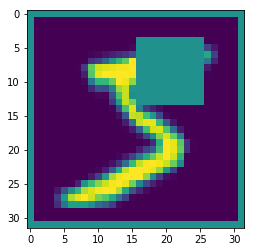

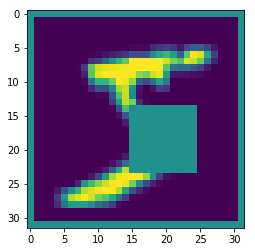

In [16]:
plt.imshow(mask_randomly(X_train[0:1])[0].reshape(32, 32))
plt.show()
plt.imshow(mask_randomly(X_train[0:1])[0].reshape(32, 32))
plt.show()

### 4. Fit model


In [17]:
epochs = 100
batch_size = 64
smooth = 0.1


# Adversarial ground truths
# real = np.ones(shape=(batch_size, 1))
# fake = np.zeros(shape=(batch_size, 1))
real = np.ones((batch_size, 4, 4, 1))
real = real * (1 - smooth)
fake = np.zeros((batch_size, 4, 4, 1))

fake_labels = to_categorical(np.full((batch_size, 1), num_classes), num_classes=num_classes+1)

d_loss = []
d_g_loss = []

for e in range(epochs + 1):
    for i in range(len(X_train) // batch_size):
        
        # Train Discriminator weights
        discriminator.trainable = True
        
        # Real samples
        img_real = X_train[i*batch_size:(i+1)*batch_size]
        real_labels = y_train[i*batch_size:(i+1)*batch_size]
        
        d_loss_real = discriminator.train_on_batch(x=img_real, y=[real, real_labels])
        
        # Fake Samples
        masked_imgs = mask_randomly(img_real)
        gen_imgs = generator.predict(masked_imgs)
        
        d_loss_fake = discriminator.train_on_batch(x=gen_imgs, y=[fake, fake_labels])
         
        # Discriminator loss
        d_loss_batch = 0.5 * (d_loss_real[0] + d_loss_fake[0])
        
        # Train Generator weights
        discriminator.trainable = False

        d_g_loss_batch = d_g.train_on_batch(x=img_real, y=real)
   
        print(
            'epoch = %d/%d, batch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, i, len(X_train) // batch_size, d_loss_batch, d_g_loss_batch[0]),
            100*' ',
            end='\r'
        )
    
    d_loss.append(d_loss_batch)
    d_g_loss.append(d_g_loss_batch[0])
    print('epoch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, d_loss[-1], d_g_loss[-1]), 100*' ')

    if e % 10 == 0:
        samples = 5
        idx = np.random.randint(0, X_train.shape[0], samples)
        x_fake = generator.predict(X_train[idx])

        for k in range(samples):
            # plot masked
            plt.subplot(2, 5, k+1)
            plt.imshow(X_train[idx[k]].reshape(32, 32), cmap='gray')
            plt.xticks([])
            plt.yticks([])

            # plot recontructed
            plt.subplot(2, 5, k+6)
            plt.imshow(x_fake[k].reshape(32, 32), cmap='gray')
            plt.xticks([])
            plt.yticks([])

        plt.tight_layout()
        plt.show()

KeyboardInterrupt: 

### 5. Evaluate model

In [ ]:
# plotting the metrics
plt.plot(d_loss)
plt.plot(d_g_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Discriminator', 'Adversarial'], loc='center right')
plt.show()

#### References

* [Semi-Supervised Learning with Context-Conditional Generative Adversarial Networks](https://arxiv.org/pdf/1611.06430.pdf)
* [How to Train a GAN? Tips and tricks to make GANs work](https://github.com/soumith/ganhacks)
* [THE MNIST DATABASE of handwritten digits](http://yann.lecun.com/exdb/mnist/)